# Vanilla Selective Prediction

This notebook contains code to evaluate the performance of vanilla Selective Prediction with your VLM for a VQA task.

The first step is to extract your VLM's predictions for your VQA task, using the `direct_vqa.py` script. This script will generate a JSON file with the predictions for each instance in your dataset, including confidence scores. You will have to run this for each split of the dataset you want.

After extracting the VLM's predictions, you need to load the prediction files for each of them. For A-OKVQA and VQAv2, we extract VLM predictions from the train and validation set, and split the train set predictions into a calib-eval and calib-train set. The calib-eval set is used for selecting the $\gamma$ thresholf for selective prediction, and we then do selective prediction of the evaluation set (in our case, the A-OKVQA validation set).

In [1]:
EXPERIMENTS_DIR = '/home/tejas/experiments/recoverr_reproduce/'
vqa_model = 'blip2flant5xl'     # Options: 'instructblipflant5xl', 'blip2flant5xl', 'llava1.57b'
dataset = 'aokvqa'      # Options: 'okvqa', 'aokvqa', 'vqav2'
mode = 'direct_answer'
conf_measure = 'yn_prob'

from tqdm import tqdm
import json
import os


VQA_MODEL_TO_DISPLAYNAME = {
    'instructblipflant5xl': 'InstructBLIP',
    'blip2flant5xl': 'BLIP2',
    'llavaplus7b': 'LLaVA-1.5-7B'
}

DATASET_TO_DISPLAYNAME = {
    'okvqa': 'OK-VQA',
    'aokvqa': 'A-OKVQA',
    'vqav2': 'VQAv2',
    'vizwiz': 'VizWiz'
}

DATASET_TO_TRAINSIZE = {
    'okvqa': 9009,
    'aokvqa': 17056, # 5000
    'vqav2': 20000,
}

DATASET_TO_VALSIZE = {
    'okvqa': 5046,
    'aokvqa': 1075,
    'vqav2': 1000
}


vqa_model_displayname =  VQA_MODEL_TO_DISPLAYNAME[vqa_model]
dataset_displayname = DATASET_TO_DISPLAYNAME[dataset]
dataset_trainsize = DATASET_TO_TRAINSIZE[dataset]
dataset_valsize = DATASET_TO_VALSIZE[dataset]

# Load directvqa outputs
directvqa_train_outputs = json.load(open(os.path.join(EXPERIMENTS_DIR, f'directvqa/{dataset}_{mode}/train_outputs/{vqa_model}_direct_vqa-1rollouts-{dataset_trainsize}examples.json')))
directvqa_eval_outputs = json.load(open(os.path.join(EXPERIMENTS_DIR, f'directvqa/{dataset}_{mode}/val_outputs/{vqa_model}_direct_vqa-1rollouts-{dataset_valsize}examples.json')))

# Partition training data into calib-train and calib-eval
calibeval_qids = list(directvqa_train_outputs.keys())
calibeval_qids = calibeval_qids[:1000]
directvqa_calibeval_outputs = {k: directvqa_train_outputs[k] for k in calibeval_qids}
directvqa_calibtrain_outputs = {k: directvqa_train_outputs[k] for k in directvqa_train_outputs if k not in calibeval_qids}

print(f"Loaded {len(directvqa_calibtrain_outputs)} qids from {vqa_model_displayname}'s {dataset_displayname} calib-train rollouts")
print(f"Loaded {len(directvqa_calibeval_outputs)} qids from {vqa_model_displayname}'s {dataset_displayname} calib-eval rollouts")
print(f"Loaded {len(directvqa_eval_outputs)} qids from {vqa_model_displayname}'s {dataset_displayname} eval rollouts")


Loaded 860 qids from BLIP2's A-OKVQA calib-train rollouts
Loaded 1000 qids from BLIP2's A-OKVQA calib-eval rollouts
Loaded 1075 qids from BLIP2's A-OKVQA eval rollouts


Now, for the calib-eval set, we wish to examine the risk and coverage at different confidence thresholds.

In [2]:
def calculate_abstention_metrics(directvqa_rollouts, threshold, error_cost=1):
    num_covered, total_risk, effective_reliability = 0, 0, 0
    qids = list(directvqa_rollouts.keys())
    abstained_qids = []
    for qid in qids:
        rollout = directvqa_rollouts[qid]
        acc = rollout['lave_score']
        conf = rollout['answer_logprobs_dict'][conf_measure]
        selected = True if conf >= threshold else False
        if selected:
            num_covered += 1
            total_risk += 1 - acc #if acc != 1 else 0
            effective_reliability += acc if acc > 0 else -error_cost
        else:
            abstained_qids.append(qid)
    coverage = num_covered/len(qids)
    risk = total_risk/num_covered if num_covered > 0 else 0
    effective_reliability = effective_reliability/len(qids)
    return coverage, risk, effective_reliability, abstained_qids

num_thresholds = 100
penalty = 1
thresholds = [i/num_thresholds for i in range(1, num_thresholds)]
coverages, risks, eff_reliabilities = [], [], []
for t in tqdm(thresholds):
    c, r, e, _ = calculate_abstention_metrics(directvqa_calibeval_outputs, t, penalty)
    coverages.append(c)
    risks.append(r)
    eff_reliabilities.append(e)


100%|██████████| 99/99 [00:00<00:00, 386.39it/s]


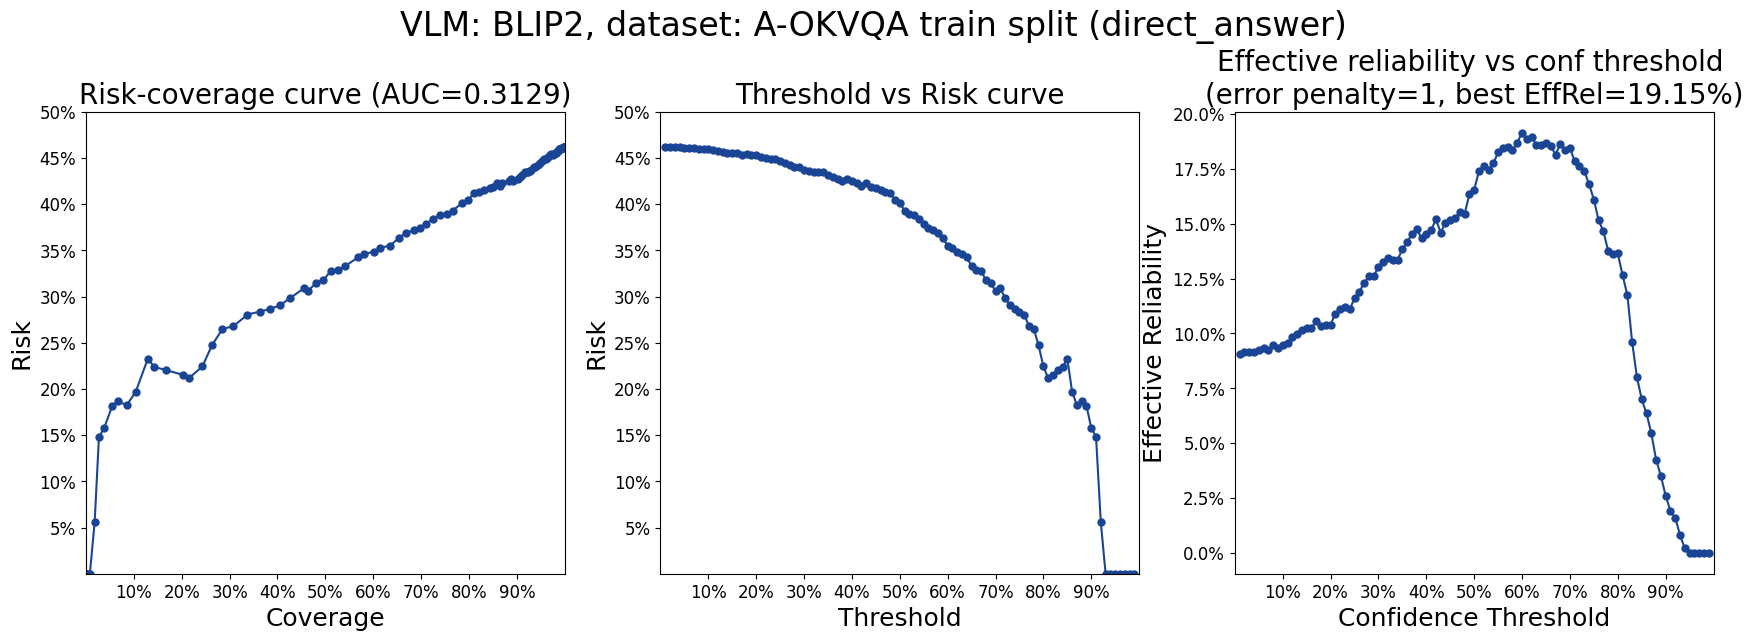

In [3]:
from sklearn import metrics
auc = metrics.auc(coverages, risks)

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'VLM: {vqa_model_displayname}, dataset: {dataset_displayname} train split ({mode})\n\n\n\n', fontsize=24, y=1.05)
fig.set_size_inches(21, 6)
ax1.plot(coverages, risks, marker='.', markersize=10, color='#1a4595')
ax1.set_title(f'Risk-coverage curve (AUC={auc:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Coverage', fontsize=18)
ax1.set_ylabel('Risk', fontsize=18)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2.plot(thresholds, risks, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax2.set_title(f'Threshold vs Risk curve', fontsize=20)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax2.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 0.5)
ax2.set_xlabel('Threshold', fontsize=18)
ax2.set_ylabel('Risk', fontsize=18)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax3.plot(thresholds, eff_reliabilities, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax3.set_title(f'Effective reliability vs conf threshold \n(error penalty={penalty}, best EffRel={max(eff_reliabilities):.2%})', fontsize=20)
ax3.set_xticks(ticks=[i/10 for i in range(1, 10)])
#ax.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlim(0, 1)
#ax.set_ylim(0, 0.5)
ax3.set_xlabel('Confidence Threshold', fontsize=18)
ax3.set_ylabel('Effective Reliability', fontsize=18)
ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

In [4]:
import os
best_er = max(eff_reliabilities)
best_er_idx = eff_reliabilities.index(best_er)
best_threshold = thresholds[best_er_idx]
print(f"Best Effective Reliability on {dataset} train set={best_er:.2%}, at confidence threshold = {best_threshold}")
print(f"At threshold={best_threshold}, train set coverage={coverages[best_er_idx]:.2%}, risk={risks[best_er_idx]:.2%}")

c, r, e, abstained_qids = calculate_abstention_metrics(directvqa_eval_outputs, best_threshold, penalty)
print(f"\nOn our evaluation set, for that threshold:")
print(f"Coverage={c:.2%}, risk={r:.2%}, effective reliability={e:.2%}")
selected_eval_score = sum(directvqa_eval_outputs[qid]['score'] for qid in directvqa_eval_outputs if qid not in abstained_qids)/(len(directvqa_eval_outputs)-len(abstained_qids))
selected_lave_score = sum(directvqa_eval_outputs[qid]['lave_score'] for qid in directvqa_eval_outputs if qid not in abstained_qids)/(len(directvqa_eval_outputs)-len(abstained_qids))
abstained_eval_score = sum(directvqa_eval_outputs[qid]['score'] for qid in directvqa_eval_outputs if qid in abstained_qids)/len(abstained_qids)
abstained_lave_score = sum(directvqa_eval_outputs[qid]['lave_score'] for qid in directvqa_eval_outputs if qid in abstained_qids)/len(abstained_qids)
print(f"Selected subset: count = {len(directvqa_eval_outputs)-len(abstained_qids)}, eval score={selected_eval_score:.2%}, LAVE score={selected_lave_score:.2%}")
print(f"Abstained subset: count = {len(abstained_qids)}, eval score={abstained_eval_score:.2%}, LAVE score={abstained_lave_score:.2%}")

c, r, e, _ = calculate_abstention_metrics(directvqa_eval_outputs, 0, penalty)
eval_score, lave_score = 0, 0
for qid in directvqa_eval_outputs:
    rollout = directvqa_eval_outputs[qid]
    eval_score += rollout['score']
    lave_score += rollout['lave_score']
print(f"\nCONFIDENCE-BLIND BASELINE: \nExact match eval score = {eval_score/len(directvqa_eval_outputs):.2%}")
print(f"LAVE eval score = {lave_score/len(directvqa_eval_outputs):.2%}")
print(f"\nIf we did not consider confidence at all (i.e. confidence threshold=0.0):")
print(f"Coverage={c:.2%}, risk={r:.2%}, effective reliability={e:.2%}")

Best Effective Reliability on aokvqa train set=19.15%, at confidence threshold = 0.6
At threshold=0.6, train set coverage=63.50%, risk=35.51%

On our evaluation set, for that threshold:
Coverage=70.79%, risk=29.57%, effective reliability=29.58%
Selected subset: count = 761, eval score=50.99%, LAVE score=70.43%
Abstained subset: count = 314, eval score=28.03%, LAVE score=35.67%

CONFIDENCE-BLIND BASELINE: 
Exact match eval score = 44.28%
LAVE eval score = 60.28%

If we did not consider confidence at all (i.e. confidence threshold=0.0):
Coverage=100.00%, risk=39.72%, effective reliability=21.58%


Now, we can evaluate our selective prediction threshold at a *specified* risk level (`DESIRED_RISK` below). We will extract the $\gamma$ threshold that achieves the specified risk level from the calib-eval outputs, and evaluate the coverage at that threshold on the evaluation outputs.

In [5]:
DESIRED_RISK = 0.2

def coverage_at_risk(desired_risk):
    gamma = min([thresholds[i] for i in range(num_thresholds-1) if risks[i] < desired_risk])
    c, r, e, abstained_qids = calculate_abstention_metrics(directvqa_eval_outputs, gamma, penalty)
    return gamma, c, r

required_gamma, vanilla_selpred_coverage, vanilla_selpred_risk = coverage_at_risk(DESIRED_RISK)
print(f"For desired risk={DESIRED_RISK:.2%}, threshold (on calib-eval set)={required_gamma}")
print(f"\tOn {dataset_displayname} evaluation set, corresponding coverage={vanilla_selpred_coverage:.2%}, risk={vanilla_selpred_risk:.2%}")

For desired risk=20.00%, threshold (on calib-eval set)=0.86
	On A-OKVQA evaluation set, corresponding coverage=14.05%, risk=12.58%


The `required_gamma` variable is the value of `vqaconfthresh_at_risk` you will need to set in your config files in `configs/recoverr_configs/` (such as [this one](https://github.com/tejas1995/ReCoVERR/src/configs/recoverr_configs/aokvqa/blip2ft5xl_uncalibrated_vlm/chatgpt_qgen-flant5xl_llm-lvis_objdet.yaml)).

The `vanilla_selpred_coverage` and `vanilla_selpred_risk` variables are the coverage and risk at the specified risk level, respectively.

Below we can visualize the coverage and risk on the calib-eval and evaluation set at different thresholds. You should see that the risk where the red line and blue curve intersect on the left graph is approximately the same as the specified risk level.

Risk-coverage levels for different thresholds (on val set):


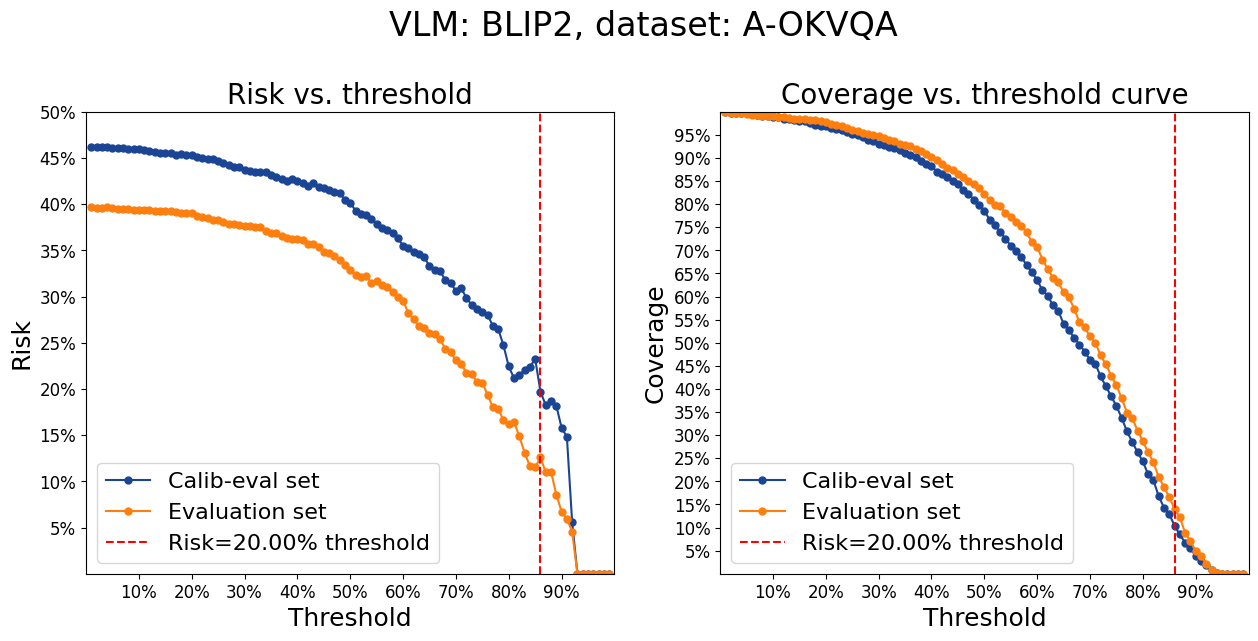

In [6]:
print(f"Risk-coverage levels for different thresholds (on val set):")
eval_coverages, eval_risks = [], []
for t in thresholds:
    c, r, e, abstained_qids = calculate_abstention_metrics(directvqa_eval_outputs, t, penalty)
    eval_coverages.append(c)
    eval_risks.append(r)

from sklearn import metrics
auc = metrics.auc(coverages, risks)

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.size = (40, 25)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'VLM: {vqa_model_displayname}, dataset: {dataset_displayname} \n\n\n', fontsize=24, y=1.05)
fig.set_size_inches(15, 6)
ax1.plot(thresholds, risks, marker='.', markersize=10, color='#1a4595', label='Calib-eval set')
ax1.plot(thresholds, eval_risks, marker='.', markersize=10, color='#ff7f0e', label='Evaluation set')
ax1.plot([required_gamma, required_gamma], [0, 1], color='red', linestyle='--', label=f'Risk={DESIRED_RISK:.2%} threshold')
ax1.set_title(f'Risk vs. threshold', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Threshold', fontsize=18)
ax1.set_ylabel('Risk', fontsize=18)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.legend(loc='lower left', fontsize=16)

ax2.plot(thresholds, coverages, marker='.', markersize=10, color='#1a4595', label='Calib-eval set')
ax2.plot(thresholds, eval_coverages, marker='.', markersize=10, color='#ff7f0e', label='Evaluation set')
ax2.plot([required_gamma, required_gamma], [0, 1], color='red', linestyle='--', label=f'Risk={DESIRED_RISK:.2%} threshold')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax2.set_title(f'Coverage vs. threshold curve', fontsize=20)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax2.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1.)
ax2.set_xlabel('Threshold', fontsize=18)
ax2.set_ylabel('Coverage', fontsize=18)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.legend(loc='lower left', fontsize=16)

plt.show()